<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

<div class="container">
        <h1 class="mb-2">Problem Statement</h1>
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

In [230]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [231]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 960x660 with 0 Axes>

In [232]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [233]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [234]:
df_train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv', index_col=0)

df_test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv', index_col=0)

df_train_orig = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv'
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv")

In [235]:
df_train.head()
df_train.shape,df_test.shape

((2190, 12), (730, 11))

In [236]:
df_train.isna().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,0


In [237]:
df_train_orig.isna().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
rainfall,0
sunshine,0


In [238]:
df_train_orig.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
df_train_orig["rainfall"] = df_train_orig["rainfall"].map({"yes":1,"no":0})
df_train_orig.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [239]:
# # Select the target variable and numerical features
# target_var = 'rainfall'
# numerical_features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train_orig[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# # Calculate the correlation between the numerical features and the target variable
# correlation_matrix = df_train[numerical_features + [target_var]].corr()

# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

In [240]:
def plot_scatter(x="feat1",y="feat2", df=df_train):

  plt.figure(figsize=(5,5))
  plt.scatter(df[x],df[y])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

In [241]:
#plot_scatter(x="day",y="sunshine")

In [242]:
print(df_train.shape)
df_train.groupby(["day"])[["pressure"]].agg(["mean","count"])
df_train.head()

(2190, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


<Axes: xlabel='id'>

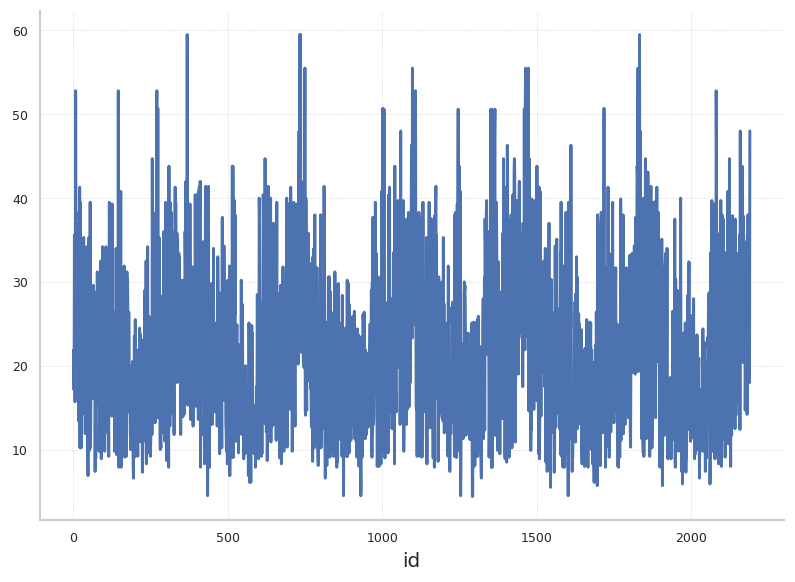

In [243]:
df_train['winddirection_rad'] = np.radians(df_train['winddirection'])
df_train['winddirection_sin'] = np.sin(df_train['winddirection_rad'])

df_train['windspeed'].plot()

In [244]:
# df_train["delta"]=df_train["day"].diff()
# df_train[(df_train["delta"]<0)&(df_train["delta"]>-364)]

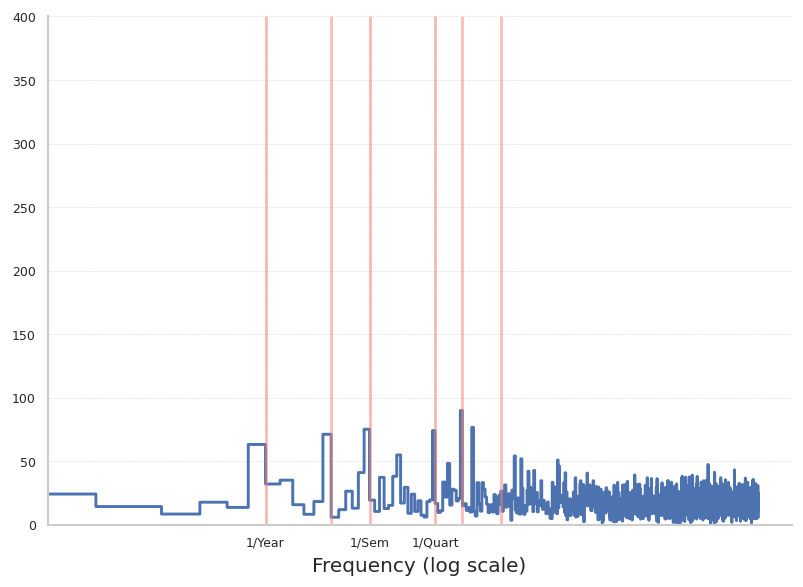

In [245]:
fft = tf.signal.rfft(df_train['rainfall'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_train['rainfall'])
days_per_year = 365
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.vlines(1.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(2.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(3.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(6.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(8.0, 0, 400, color='salmon', alpha=0.5)
plt.vlines(12, 0, 400, color='salmon', alpha=0.5)


plt.ylim(0, 400)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 3, 6], labels=['1/Year', '1/Sem', '1/Quart'])
_ = plt.xlabel('Frequency (log scale)')

**Descriptions of Loan Data**

Descriptions for the column names based on the data provided:

* **id**: Unique identifier for each record.
* **person_age**: Age of the individual, categorized into ranges.
* **person_income**: Income of the individual, categorized into income ranges.
* **person_home_ownership**: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
* **person_emp_length**: Employment length of the individual, categorized into ranges based on years.
* **loan_intent**: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
* **loan_grade**: The credit grade of the loan, such as 'A', 'B', etc.
* **loan_amnt**: Loan amount, categorized into ranges.
* **loan_int_rate**: Loan interest rate, categorized into percentage ranges.
* **loan_percent_income**: Percentage of the individual’s income that the loan represents, categorized into - ranges.
* **cb_person_default_on_file**: Whether the person has a history of loan default, with values 'true' or 'false'.
* **cb_person_cred_hist_length**: Length of the individual’s credit history, categorized into ranges.
* **loan_status**: with values representing whether the loan status approval( binary values)

The dataset is a about loan applications, including personal, financial, and loan details. It's likely used for predicting whether a person will default on a loan, making it a binary classification problem. The goal is to figure out which applicants are at higher risk of not paying back their loans based on their age, income, employment, loan purpose, credit history, and other related information.

In [246]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'rainfall'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv")
    train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/Rainfall.csv")

    train_org.rename({"pressure ":"pressure","humidity ":"humidity","cloud ":"cloud","         winddirection":"winddirection"},axis=1,inplace=True)
    train_org["rainfall"] = train_org["rainfall"].map({"yes":1,"no":0})

    original_data = 'N'
    overwrite_data = 'Y'
    outliers = 'N'
    log_trf = 'N'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'N'
    force_normalization="N"
    impose_normalization="N"
    trg_enc = "N"
    metric_goal="AUC"
    direction_="maximize"
    log_trans_cols = []
    force_norm_cols = []
    impose_norm_cols = []
    trg_enc_feat = []

In [247]:
class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

In [248]:
class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        #self.cat_feature_plots()
        self.target_pie()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isna().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):

            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            ax = axes[i,1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

## 1.0 EDA


Train head



,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.400024,21.200001,20.600000,19.900000,19.400000,87.000000,88.000000,1.100000,60.000000,17.200001,1
1,2,1019.500000,16.200001,16.900000,15.800000,15.400000,95.000000,91.000000,0.000000,50.000000,21.900000,1
2,3,1024.099976,19.400000,16.100000,14.600000,9.300000,75.000000,47.000000,8.300000,70.000000,18.100000,1
3,4,1013.400024,18.100000,17.799999,16.900000,16.799999,95.000000,95.000000,0.000000,60.000000,35.599998,1
4,5,1021.799988,21.299999,18.400000,15.200000,9.600000,52.000000,45.000000,3.600000,40.000000,24.799999,0



Train info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int32  
 1   pressure       2190 non-null   float32
 2   maxtemp        2190 non-null   float32
 3   temparature    2190 non-null   float32
 4   mintemp        2190 non-null   float32
 5   dewpoint       2190 non-null   float32
 6   humidity       2190 non-null   float32
 7   cloud          2190 non-null   float32
 8   sunshine       2190 non-null   float32
 9   winddirection  2190 non-null   float32
 10  windspeed      2190 non-null   float32
 11  rainfall       2190 non-null   int32  
dtypes: float32(10), int32(2)
memory usage: 102.8 KB


None


Train describe



,mean,std,min,25%,50%,75%,max
day,179.948,105.204,1.000,89.000,178.500,270.000,365.000
pressure,1013.602,5.655,999.000,1008.600,1013.000,1017.775,1034.600
maxtemp,26.366,5.654,10.400,21.300,27.800,31.200,36.000
temparature,23.953,5.222,7.400,19.300,25.500,28.400,31.500
mintemp,22.170,5.059,4.000,17.700,23.850,26.400,29.800
dewpoint,20.455,5.288,-0.300,16.800,22.150,25.000,26.700
humidity,82.037,7.801,39.000,77.000,82.000,88.000,98.000
cloud,75.722,18.027,2.000,69.000,83.000,88.000,100.000
sunshine,3.744,3.626,0.000,0.400,2.400,6.800,12.100
winddirection,104.863,80.002,10.000,40.000,70.000,200.000,300.000



Train missing values



,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,0



Test head



,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1019.500000,17.500000,15.800000,12.700000,14.900000,96.000000,99.000000,0.000000,50.000000,24.299999
1,2,1016.500000,17.500000,16.500000,15.800000,15.100000,97.000000,99.000000,0.000000,50.000000,35.299999
2,3,1023.900024,11.200000,10.400000,9.400000,8.900000,86.000000,96.000000,0.000000,40.000000,16.900000
3,4,1022.900024,20.600000,17.299999,15.200000,9.500000,75.000000,45.000000,7.100000,20.000000,50.599998
4,5,1022.200012,16.100000,13.800000,6.400000,4.300000,68.000000,49.000000,9.200000,20.000000,19.400000



Test info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int32  
 1   pressure       730 non-null    float32
 2   maxtemp        730 non-null    float32
 3   temparature    730 non-null    float32
 4   mintemp        730 non-null    float32
 5   dewpoint       730 non-null    float32
 6   humidity       730 non-null    float32
 7   cloud          730 non-null    float32
 8   sunshine       730 non-null    float32
 9   winddirection  729 non-null    float32
 10  windspeed      730 non-null    float32
dtypes: float32(10), int32(1)
memory usage: 31.5 KB


None


Test describe



,mean,std,min,25%,50%,75%,max
day,183.000,105.438,1.000,92.000,183.000,274.000,365.000
pressure,1013.503,5.506,1000.000,1008.725,1012.700,1017.600,1032.200
maxtemp,26.372,5.673,7.400,21.600,27.800,31.000,35.800
temparature,23.963,5.278,5.900,19.825,25.650,28.375,31.800
mintemp,22.110,5.171,4.200,17.825,23.900,26.400,29.100
dewpoint,20.460,5.391,-0.000,16.800,22.300,25.000,26.700
humidity,82.670,7.819,39.000,77.250,82.000,89.000,98.000
cloud,76.360,17.934,0.000,69.000,83.000,88.000,100.000
sunshine,3.664,3.639,0.000,0.325,2.200,6.675,11.800
winddirection,103.923,81.695,10.000,40.000,70.000,200.000,300.000



Test missing values



,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,1



Correlation Heatmap



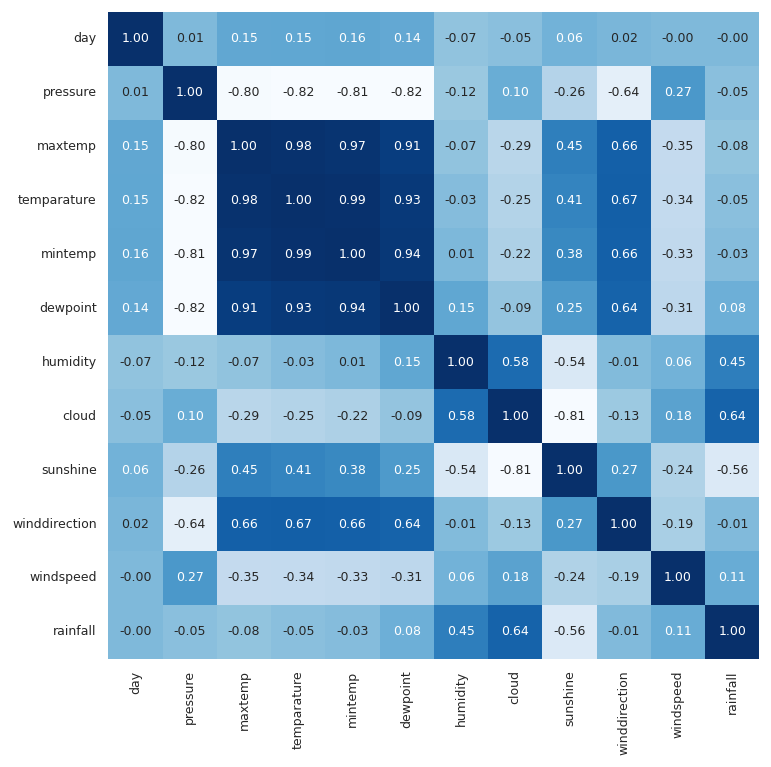


Distribution analysis - Numerical



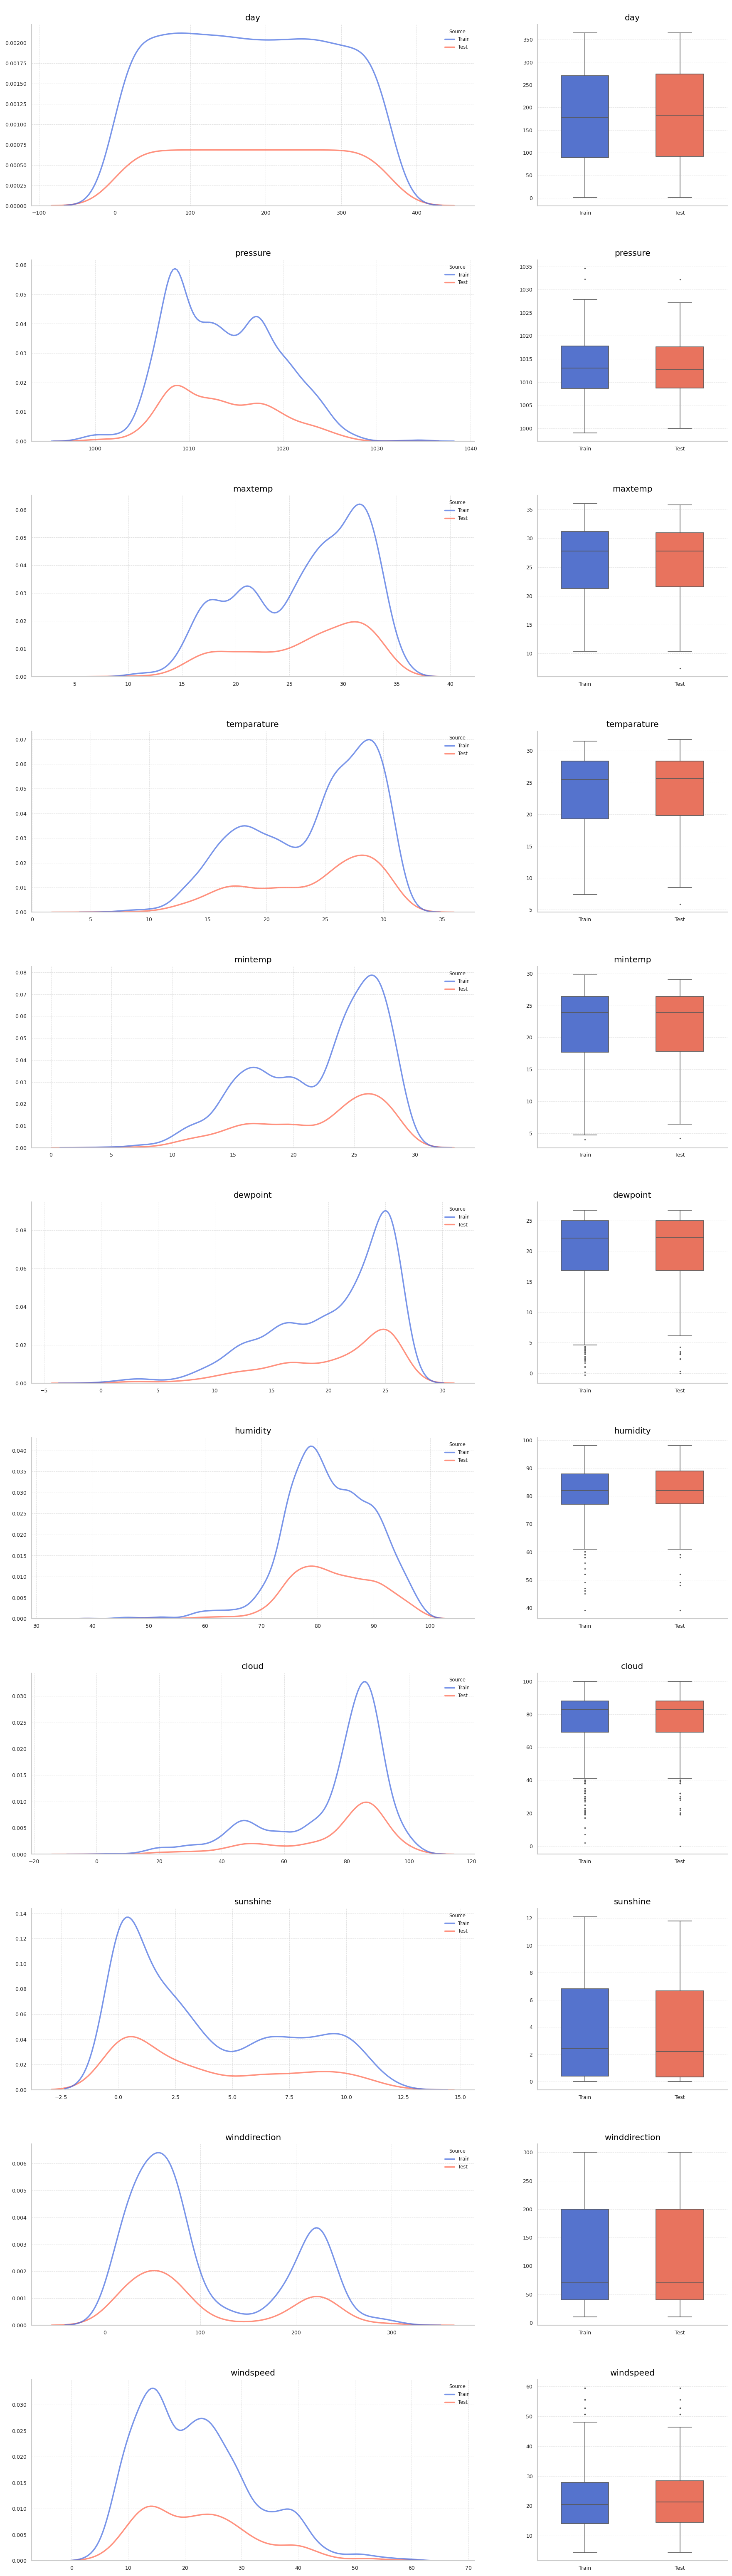


Target feature distribution



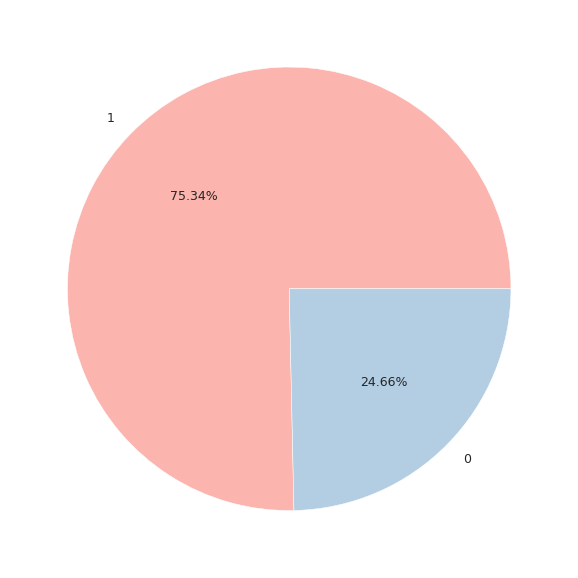

In [249]:
eda = EDA()

## 2.0 Data Transformation and Feature Negeneering:

In [250]:
class Transform(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        if self.missing == 'Y':
            self.missing_values()

        self.train_raw = self.train.copy()

        if self.overwrite_data == 'Y':
            self.train = self.overwrite(self.train)
            self.test = self.overwrite(self.test)

        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()

        if self.outliers == 'Y':
            self.remove_outliers()

        if self.log_trf == 'Y':
            self.log_transformation()

        if self.force_normalization == 'Y':
            self.forced_norm_transformation()

        if self.impose_normalization == 'Y':
            self.impose_normalization_transformation()

        if self.trg_enc == 'Y':
            self.target_encoding()

        if self.scaler_trf == 'Y':
            self.scaler()

        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()

    def __call__(self):

        self.train[self.cat_features] = self.train[self.cat_features].astype('category')
        self.test[self.cat_features] = self.test[self.cat_features].astype('category')
        data = pd.concat([self.test, self.train])
        self.train_enc, self.test_enc = self.encode(data)

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(1 + data[f].max())

        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)

 #       scaler = StandardScaler()
 #       self.train_enc[self.num_features] = scaler.fit_transform(self.train_enc[self.num_features])
 #       self.test_enc[self.num_features] = scaler.transform(self.test_enc[self.num_features])

        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features


    def encode(self, data):

        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')

        train_enc = data[~data[self.target].isna()]
        test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
        return train_enc, test_enc

    def overwrite(self, df):

        # Iterate through the rows, starting from the second row
        for i in range(1, len(df)):

            # Calculate the difference between the current day and the previous day
            diff = df.loc[i, 'day'] - df.loc[i-1, 'day']

            # If the difference is greater than 1, replace the current day with the previous day plus 1
            if diff > -360:
                df.loc[i, 'day'] = df.loc[i-1, 'day'] + 1

        return df

    def new_features(self, df):

        # Wind Speed and direction:
        #Replace Some entries that appears wrong in the dataset:
        wv = df['windspeed']

        # Convert to radians.
        wd_rad = df.pop('winddirection')*np.pi / 180

        # Calculate the wind x and y components.
        df['Wdx'] = np.cos(wd_rad)
        df['Wdy'] = np.sin(wd_rad)

        # Calculate the wind x and y components.
        df['Wdsx'] = wv*np.cos(wd_rad)
        df['Wdsy'] = wv*np.sin(wd_rad)

        # Temporal Features:
        # Annual Seasonalities:
        df['Year_sin'] = np.sin(df['day'] * (2 * np.pi / 365))
        df['Year_cos'] = np.cos(df['day'] * (2 * np.pi / 365))
        # Semester Seasonalities:
        df['sem_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 2)))
        df['sem_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 2)))
        # 4-time a year Seasonalities:
        df['m4_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 3)))
        df['m4_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 3)))
        # 6-time a year Seasonalities:
        df['m6_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 6)))
        df['m6_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 6)))
        # 8-time a year Seasonalities:
        df['m8_sin'] = np.sin(df['day'] * (2 * np.pi / (365/ 8)))
        df['m8_cos'] = np.cos(df['day'] * (2 * np.pi / (365/ 8)))



        # Month of the year:
        # Define the number of days in each month
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


        return df

    def log_transformation(self):

        self.train[self.log_trans_cols] = np.log1p(self.train[self.log_trans_cols])
        self.test[self.log_trans_cols] = np.log1p(self.test[self.log_trans_cols])

        return self

    def forced_norm_transformation(self):

        self.train[self.force_norm_cols] = np.sqrt(self.train[self.force_norm_cols]+0.1)
        self.test[self.force_norm_cols] = np.sqrt(self.test[self.force_norm_cols]+0.1)

        return self

    def impose_normalization_transformation(self):

        scaler = QuantileTransformer(output_distribution='normal',subsample=20_000,random_state=42)
        self.train[self.impose_norm_cols] = scaler.fit_transform(self.train[self.impose_norm_cols])
        self.test[self.impose_norm_cols] = scaler.transform(self.test[self.impose_norm_cols])

        return self


    def distribution(self):

        print(Style.BRIGHT+Fore.RED+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=len(self.num_features), ncols=2, figsize=(15, len(self.num_features)*5))

        for (ax_r, ax_n), col in zip(axes, self.num_features):

            ax_r.set_title(f'{col} ($\mu=$ {self.train_raw[col].mean():.2f} and $\sigma=$ {self.train_raw[col].std():.2f} )')
            ax_r.hist(self.train_raw[col], bins=30, color='tomato',alpha=0.7)
            ax_r.axvline(self.train_raw[col].mean(), color='r', label='Mean')
            ax_r.axvline(self.train_raw[col].median(), color='y', linestyle='--', label='Median')
            ax_r.legend()

            ax_n.set_title(f'{col} Normalized ($\mu=$ {self.train[col].mean():.2f} and $\sigma=$ {self.train[col].std():.2f} )')
            ax_n.hist(self.train[col], bins=30, color='royalblue',alpha=0.7)
            ax_n.axvline(self.train[col].mean(), color='r', label='Mean')
            ax_n.axvline(self.train[col].median(), color='y', linestyle='--', label='Median')
            ax_n.legend()

    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True)

    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(self.train[self.num_features])
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self

    def missing_values(self):

        self.train[self.num_features] = self.train[self.num_features].fillna(self.train[self.num_features].median())
        self.test[self.num_features] = self.test[self.num_features].fillna(self.test[self.num_features].median())
        for column in self.cat_features:
            self.train[column] = self.train[column].fillna(self.train[column].mode()[0])
            self.test[column] = self.test[column].fillna(self.test[column].mode()[0])
        return self

    def target_encoding(self):
        te = TargetEncoder()
        self.train[self.trg_enc_feat] = te.fit_transform(self.train[self.trg_enc_feat],self.train[self.target])
        self.test[self.trg_enc_feat] = te.transform(self.test[self.trg_enc_feat])

        for a in self.cat_features:
            self.cat_features.remove(a)

        return self

    @property
    def cat_features(self):
        return self._cat_features

    @cat_features.setter
    def cat_features(self, cat_features):
        self._cat_features = cat_features

    @property
    def num_features(self):
        return self._num_features

    @num_features.setter
    def num_features(self, num_features):
        self._num_features = num_features

    @property
    def cat_features_card(self):
        return self._cat_features_card

    @cat_features_card.setter
    def cat_features_card(self, cat_features_card):
        self._cat_features_card = cat_features_card

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, train):
        self._train = train

    @property
    def direction(self):
        return self._direction

    @direction.setter
    def direction(self, direction):
        self._direction= direction

In [251]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

In [252]:
X_enc.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,Wdx,Wdy,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03,2.190000e+03
mean,183.000000,1013.602051,26.365799,23.953056,22.170092,20.454567,82.036530,75.721916,3.744429,21.804703,0.146225,0.331289,4.453804,8.436069,0.000000e+00,-8.760116e-17,2.595590e-17,-1.119348e-16,0.000000e+00,-1.103126e-16,4.055609e-18,-1.009847e-16,1.216683e-18,-1.127459e-16
std,105.390093,5.655362,5.654336,5.222408,5.059124,5.288412,7.800655,18.026501,3.626330,9.898644,0.665759,0.652709,15.241985,15.820310,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01,7.072683e-01
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,4.400000,-1.000000,-1.000000,-52.799999,-41.158535,-9.999907e-01,-9.999630e-01,-9.999907e-01,-9.999630e-01,-9.999907e-01,-9.999630e-01,-9.999907e-01,-9.999630e-01,-9.999907e-01,-9.999630e-01
25%,92.000000,1008.599976,21.299999,19.299999,17.700001,16.799999,77.000000,69.000000,0.400000,14.125000,-0.642788,-0.342020,-8.354649,-4.150198,-7.055836e-01,-7.086267e-01,-7.055836e-01,-7.086267e-01,-7.055836e-01,-7.086267e-01,-7.055836e-01,-7.086267e-01,-7.055836e-01,-7.086267e-01
50%,183.000000,1013.000000,27.799999,25.500000,23.849999,22.150001,82.000000,83.000000,2.400000,20.500000,0.342020,0.642788,6.783585,9.820010,-2.449294e-16,4.303538e-03,-4.898587e-16,4.303538e-03,-7.347881e-16,4.303538e-03,-1.469576e-15,4.303538e-03,-1.959435e-15,4.303538e-03
75%,274.000000,1017.774994,31.200001,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,27.900000,0.766044,0.866025,14.830528,18.997902,7.055836e-01,7.025275e-01,7.055836e-01,7.025275e-01,7.055836e-01,7.025275e-01,7.055836e-01,7.025275e-01,7.055836e-01,7.025275e-01
max,365.000000,1034.599976,36.000000,31.500000,29.799999,26.700001,98.000000,100.000000,12.100000,59.500000,0.984808,1.000000,55.911709,50.700001,9.999907e-01,1.000000e+00,9.999907e-01,1.000000e+00,9.999907e-01,1.000000e+00,9.999907e-01,1.000000e+00,9.999907e-01,1.000000e+00


30.416666666666668

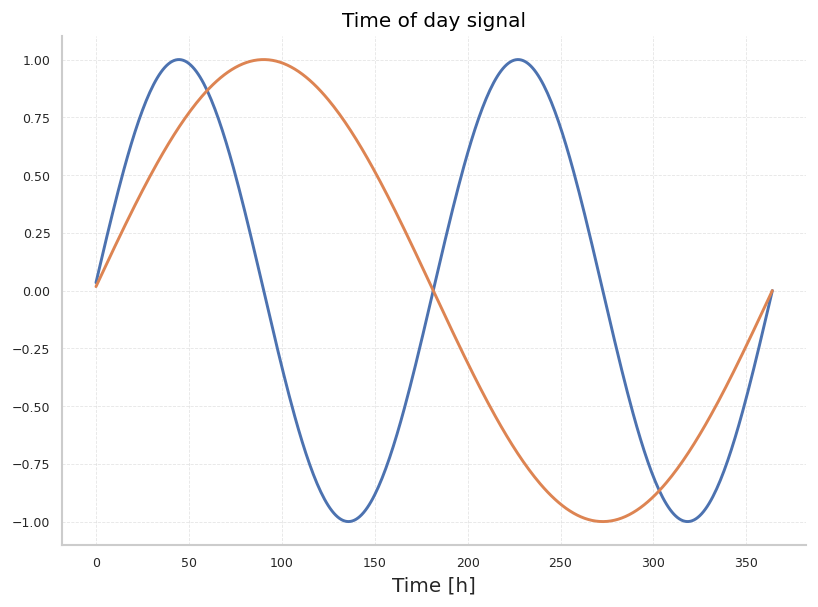

In [253]:
plt.plot(np.array(X_enc['sem_sin'])[:365])
plt.plot(np.array(X_enc['Year_sin'])[:365])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
365/12

(-52.79999923706055, 55.91170883178711, -41.15853500366211, 50.70000076293945)

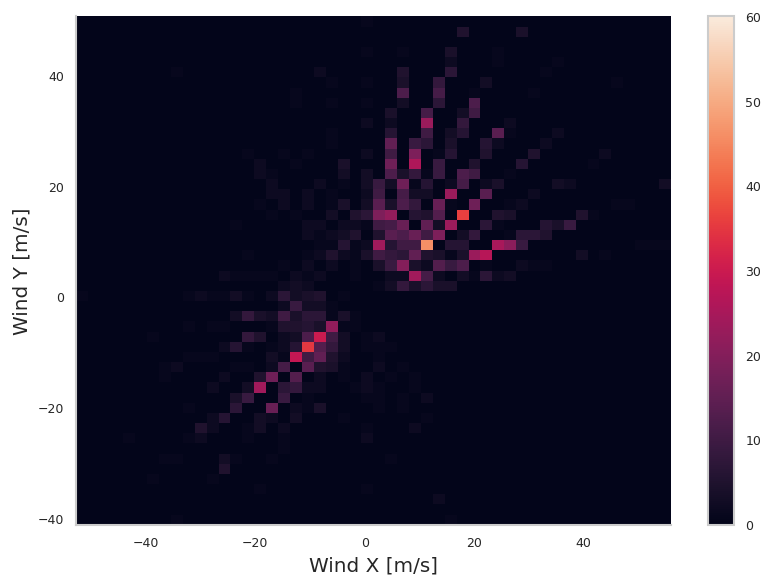

In [254]:
plt.hist2d(X_enc['Wdsx'], X_enc['Wdsy'], bins=(50, 50), vmax=60)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [255]:
X.shape, X_enc.shape, test.shape, test_enc.shape

((2190, 24), (2190, 24), (730, 24), (730, 24))

In [256]:
X_enc_ext = X_enc.copy()
X_enc_ext["rainfall"] = y

In [267]:
X_enc_ext[["temparature","sunshine"]].describe()

,temparature,sunshine
count,2190.000000,2190.000000
mean,23.953056,3.744429
std,5.222408,3.626330
min,7.400000,0.000000
25%,19.299999,0.400000
50%,25.500000,2.400000
75%,28.400000,6.800000
max,31.500000,12.100000


In [258]:
corr_verify

-0.02860593006039851

In [259]:
# columns_delta = [ 'rainfall',"temparature"]

# for col in columns_delta:
#   for delta in range(1, 8):
#     verify_lag = X_enc_ext[col].shift(delta).fillna(1)
#     df_corr = pd.concat([X_enc_ext[["rainfall"]],verify_lag],axis=1)
#     corr_verify = df_corr.corr().iloc[0,1]

#     print(f"{col} with lag {delta} corr: {corr_verify}")

In [290]:
X_enc_ext["temp_diff"] = X_enc_ext["maxtemp"] - X_enc_ext["mintemp"]
X_enc_ext["dist_dew"] = (X_enc_ext["temparature"] - X_enc_ext["dewpoint"])/X_enc_ext["temparature"]
X_enc_ext["range_dist_dew"] = (X_enc_ext["temp_diff"])*(X_enc_ext["temparature"] - X_enc_ext["dewpoint"])
X_enc_ext["temp_diff_clouds"] = np.log1p((X_enc_ext["sunshine"])/X_enc_ext["cloud"])
#X_enc_ext["temp_diff_humidity"] = X_enc_ext["temp_diff"]*X_enc_ext["humidity"]

# Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
X_enc_ext['Pressure_Humidity_Interaction'] = X_enc_ext['pressure'] * X_enc_ext['humidity']

# Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
X_enc_ext['Wind_Cloud_Interaction'] = X_enc_ext['windspeed'] * X_enc_ext['cloud']

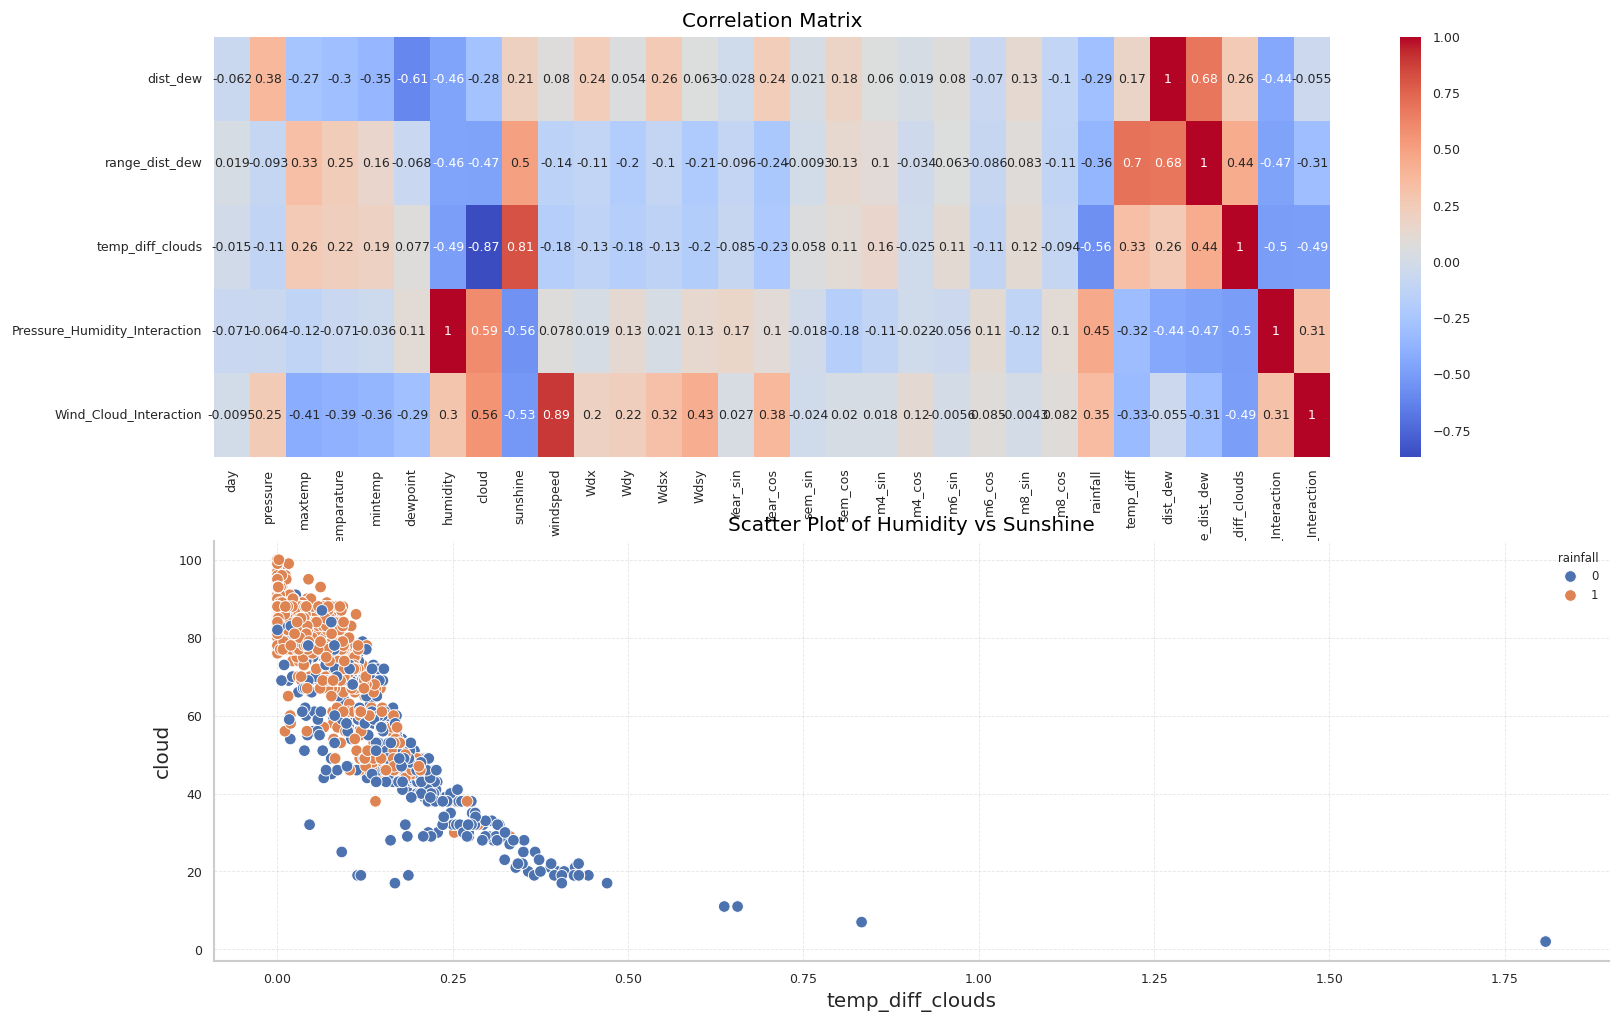

<Figure size 1200x720 with 0 Axes>

In [291]:
# Calculate the correlation between the numerical features and the target variable
correlation_matrix = X_enc_ext.corr()
fig,ax=plt.subplots(2,1,figsize=(15,10))

# Plot the heatmap
sns.heatmap(correlation_matrix.iloc[-5:,:], annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Correlation Matrix')

# Create a scatter plot of `humidity` vs `sunshine`
x1='temp_diff_clouds'
x2='cloud'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x1, y=x2, hue='rainfall', data=X_enc_ext,ax=ax[1])
ax[1].set_title('Scatter Plot of Humidity vs Sunshine')
ax[1].set_xlabel(x1)
ax[1].set_ylabel(x2)
plt.tight_layout()
plt.show()

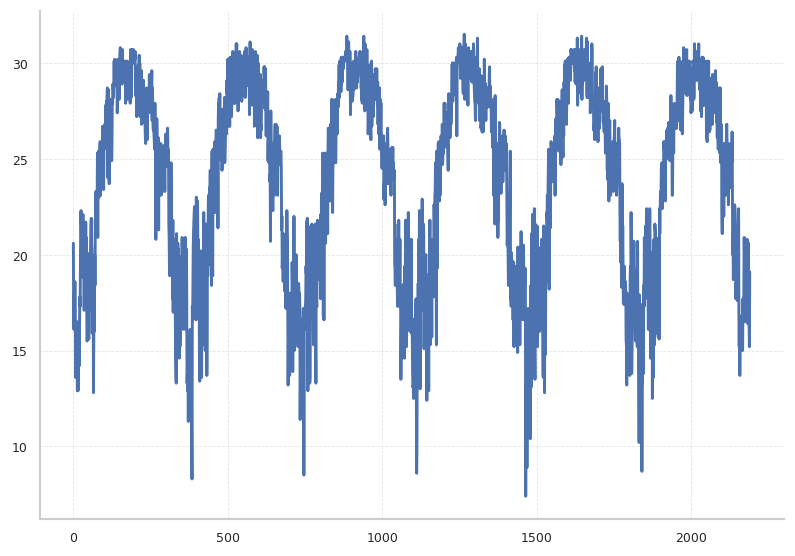

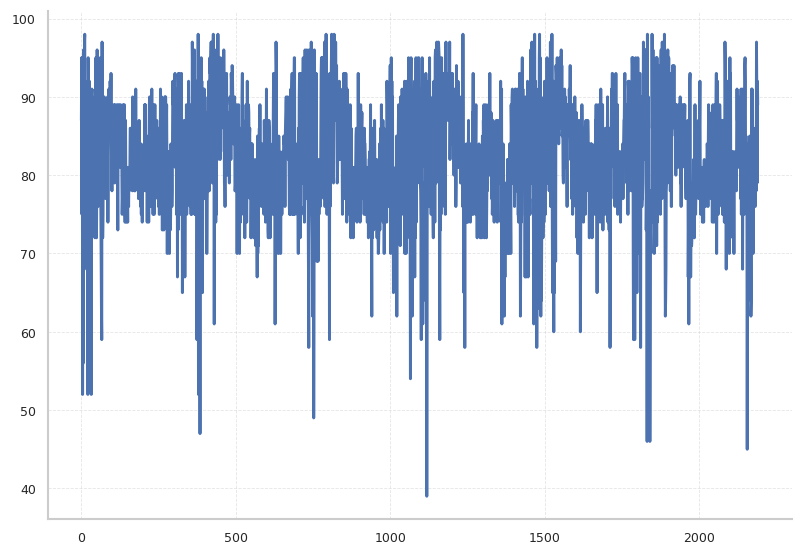

In [269]:
X_enc_ext.temparature.plot()
plt.show()
X_enc_ext.humidity.plot()
plt.show()

#imputer = MixedDataImputer(X_enc, test_enc)

In [69]:
#train_df_imputed, test_df_imputed = imputer.transform()

In [70]:
#train_df_imputed.isna().sum()

## 3.0 Advanced Feature Engeneering

In [59]:
X_enc.sample(3)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,Wdx,Wdy,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos
372,8,1022.599976,15.900000,11.300000,10.800000,7.7,81.0,78.0,2.2,29.6,0.939693,0.342020,27.814901,10.123796,0.137279,0.990532,0.271958,0.962309,0.401488,0.915864,0.735417,0.677615,0.891981,0.452072
1395,301,1013.700012,26.299999,24.400000,23.299999,19.9,91.0,74.0,3.1,38.0,0.342020,0.939693,12.996762,35.708321,-0.891981,0.452072,-0.806480,-0.591261,0.162807,-0.986658,-0.321270,0.946988,-0.573772,-0.819015
2055,231,1003.799988,29.100000,28.700001,27.700001,24.5,93.0,84.0,1.6,27.1,-0.642788,-0.766045,-17.419542,-20.759808,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.956235,0.292600,0.385663,0.922640


In [60]:
X_enc_y = pd.concat([X_enc, y], axis=1)
X_enc_y.sample(3)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,Wdx,Wdy,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,rainfall
719,355,1016.700012,19.600000,18.9,17.200001,16.500000,83.0,81.0,0.6,38.299999,0.173648,0.984808,6.650722,37.718136,-0.171293,0.985220,-0.337523,0.941317,-0.493776,0.869589,-0.858764,0.512371,-0.981306,0.192452,1
119,120,1007.900024,31.200001,28.1,26.400000,24.299999,85.0,90.0,3.9,23.299999,-0.642788,0.766044,-14.976952,17.848835,0.880012,-0.474951,-0.835925,-0.548843,-0.085965,0.996298,-0.171293,0.985220,-0.729558,-0.683919,1
2150,326,1020.799988,21.200001,19.9,17.100000,15.600000,77.0,88.0,0.2,15.500000,0.642788,0.766044,9.963207,11.873689,-0.622047,0.782980,-0.974100,0.226116,-0.903356,-0.428892,0.774884,-0.632103,0.790946,0.611886,1


In [65]:
X_enc_y.info()
t.cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          2190 non-null   int32  
 1   pressure     2190 non-null   float32
 2   maxtemp      2190 non-null   float32
 3   temparature  2190 non-null   float32
 4   mintemp      2190 non-null   float32
 5   dewpoint     2190 non-null   float32
 6   humidity     2190 non-null   float32
 7   cloud        2190 non-null   float32
 8   sunshine     2190 non-null   float32
 9   windspeed    2190 non-null   float32
 10  Wdx          2190 non-null   float32
 11  Wdy          2190 non-null   float32
 12  Wdsx         2190 non-null   float32
 13  Wdsy         2190 non-null   float32
 14  Year_sin     2190 non-null   float64
 15  Year_cos     2190 non-null   float64
 16  sem_sin      2190 non-null   float64
 17  sem_cos      2190 non-null   float64
 18  m4_sin       2190 non-null   float64
 19  m4_cos     

[]

In [72]:
class plot_class():

    def __init__(self,df, target_variable, features_cat,features_num):
      self.df = df
      self.target_variable = target_variable
      self.features_cat = features_cat
      self.features_num = features_num

    @classmethod
    def plot_categorical_features(cls, df, target_variable, features_cat, features_num):
        """
        Plots the frequency of the target variable for each value of multiple categorical features.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the categorical feature columns to plot.
        """

        num_features = len(features_cat)
        if num_features>0:
          num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

          fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
          axes = axes.flatten()  # Flatten the axes array for easier iteration

          for i, feature in enumerate(features_cat):
              cross_tab = pd.crosstab(df[feature], df[target_variable])
              cross_tab.plot(kind='bar', stacked=False, position=0.3, width=0.4, ax=axes[i],colormap=palette_1, alpha=0.6)
              axes[i].set_xlabel(feature)
              axes[i].set_ylabel('Frequency')
              axes[i].set_title(f'Frequency of {target_variable} by {feature}')

          # Hide any unused subplots
          for i in range(num_features, len(axes)):
              axes[i].axis('off')

          plt.tight_layout()
          plt.show()

        else:
          print("No categorical features to plot.")

        return cls(df, target_variable, features_cat, features_num)

    @classmethod
    def plot_numerical_features(cls, df, target_variable, features_cat, features_num):
        """
        Generates violin plots for numerical features, showing the distribution for each target class.

        Args:
          df: Pandas DataFrame containing the data.
          target_variable: Name of the target variable column in the DataFrame.
          features: List of names of the numerical feature columns to plot.
        """

        num_features = len(features_num)
        num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
        axes = axes.flatten()  # Flatten the axes array for easier iteration

        for i, feature in enumerate(features_num):
            sns.violinplot(x=target_variable, y=feature, data=df, ax=axes[i],
                           hue=target_variable,  # Use 'hue' to color by target class
                           palette=palette_9)
            axes[i].set_xlabel(target_variable)
            axes[i].set_ylabel(feature)
            axes[i].set_title(f'Distribution of {feature} by {target_variable}')

        # Hide any unused subplots
        for i in range(num_features, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        return cls(df, target_variable, features_cat, features_num)

    def scatter_comp(self, feat_01, feat_02, hue_def):
        """
        Generates a scatter plot between two features, colored by a third
        categorical feature using Seaborn.

        Args:
          df: Pandas DataFrame containing the data.
          x_feature: Name of the feature to plot on the x-axis.
          y_feature: Name of the feature to plot on the y-axis.
          color_feature: Name of the categorical feature to use for coloring.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            x=feat_01,
            y=feat_02,
            hue=hue_def,  # Use 'hue' for color encoding
            data=self.df,
            ax=ax
        )

        plt.xlabel(feat_01)
        plt.ylabel(feat_02)
        plt.title(f'ScatterPlot of {feat_01} vs. {feat_02} colored by {hue_def}')
        plt.show()

    def heatmap_corr(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.df.select_dtypes(exclude='int').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = "Reds", annot=True, cbar=False)
        plt.show()

In [73]:
plot_instance = plot_class.plot_categorical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=t.num_features);

No categorical features to plot.


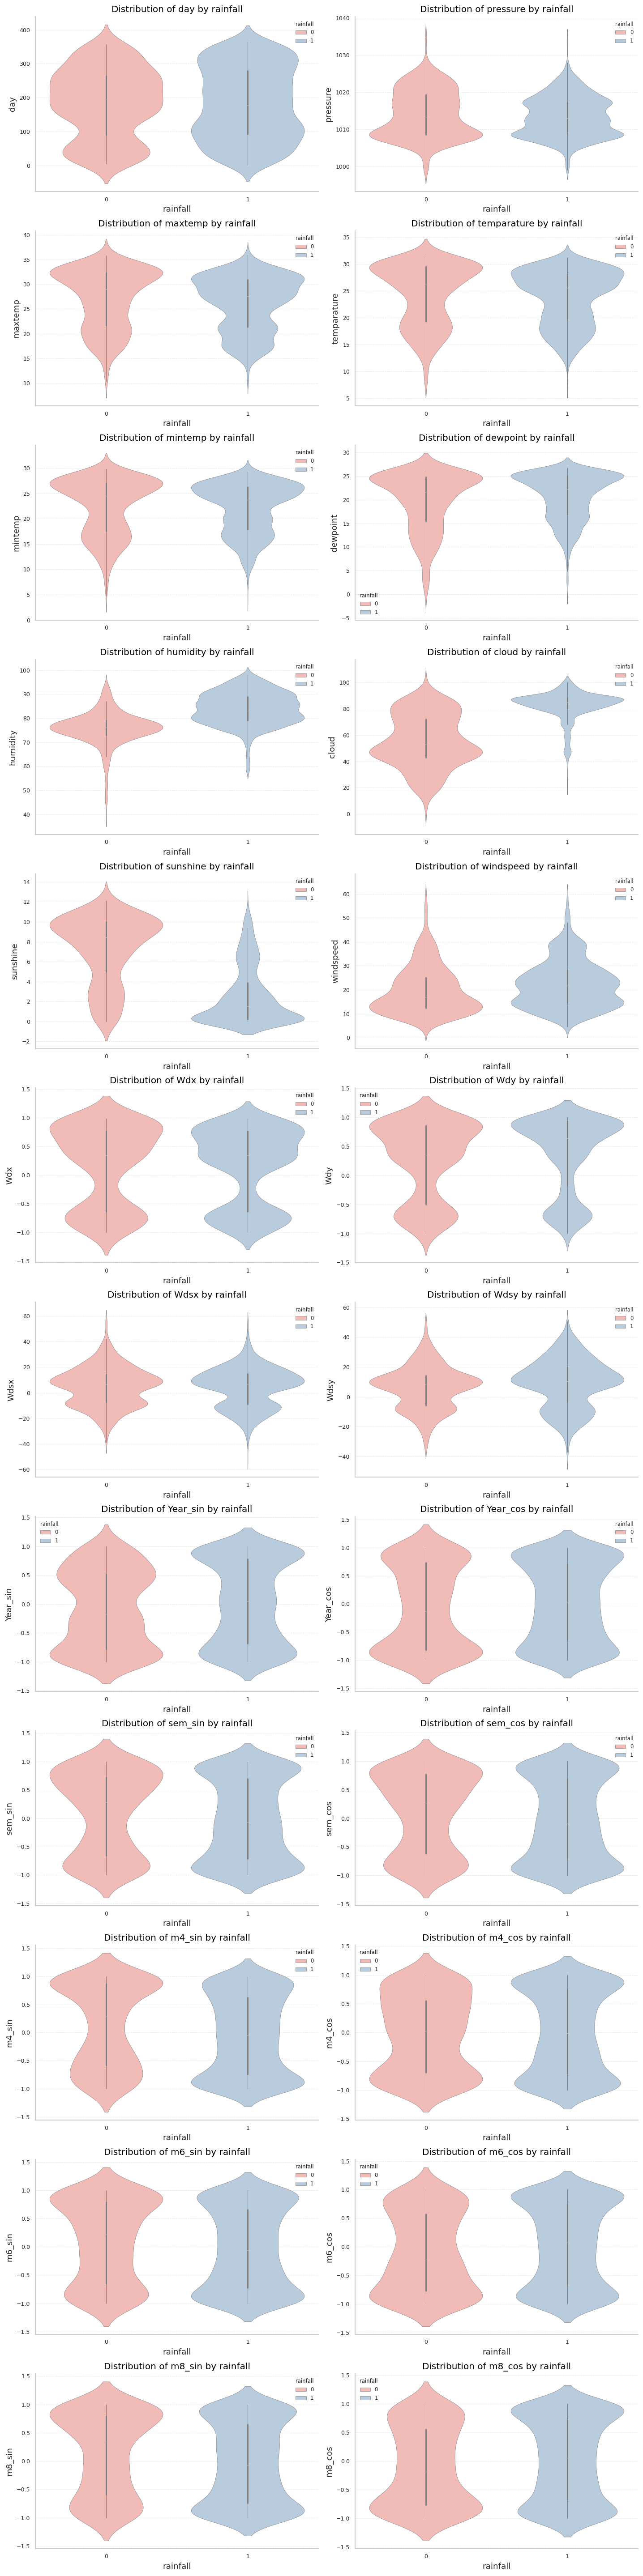

In [74]:
plot_instance.plot_numerical_features(df=X_enc_y, target_variable="rainfall", features_cat=t.cat_features, features_num=t.num_features);

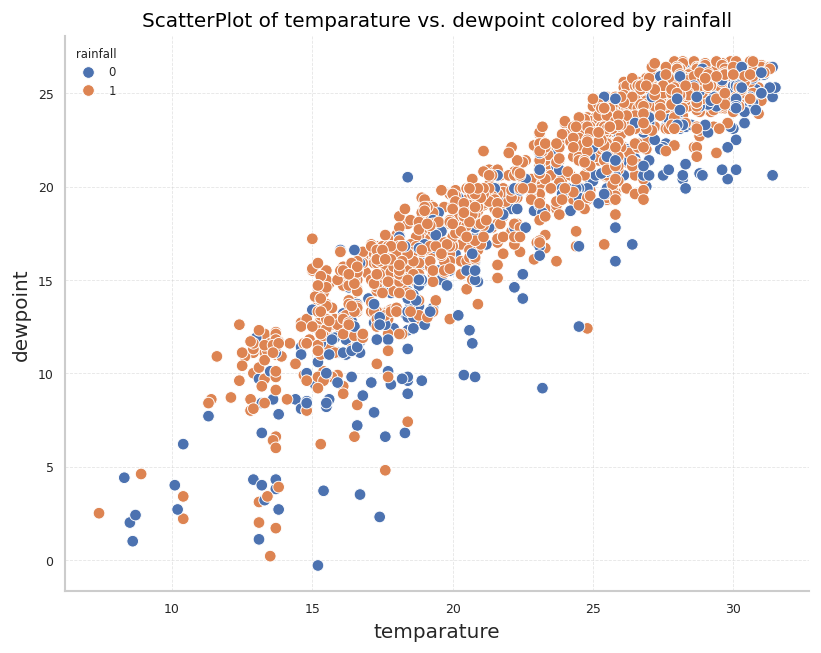

In [121]:
plot_instance.scatter_comp(feat_01="temparature", feat_02="dewpoint", hue_def="rainfall")


Correlation Heatmap



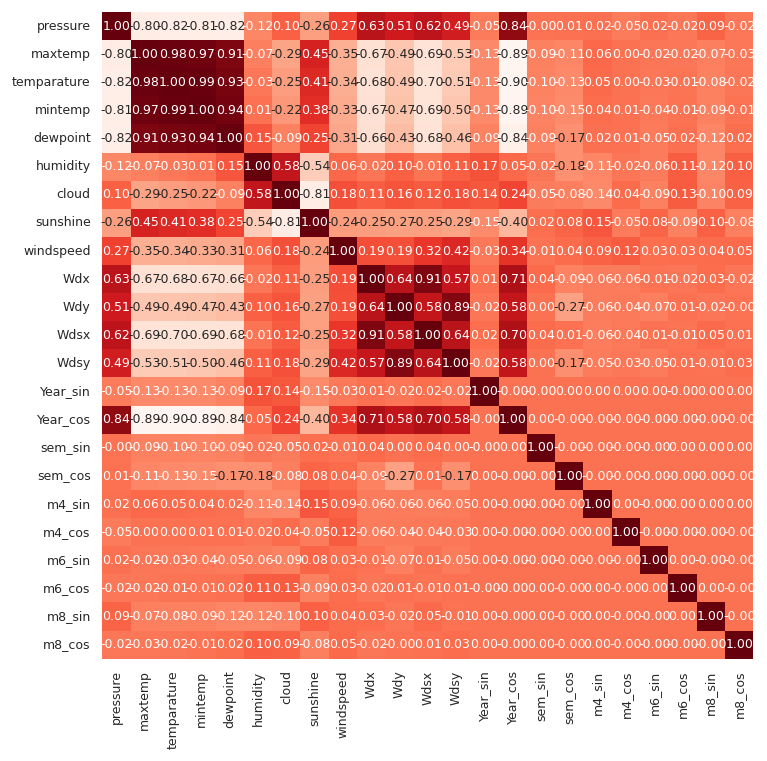

In [75]:
plot_instance.heatmap_corr()

## **4.0 MODELS**

--------------------

### **4.1 TREE BASED MODELS**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

sample_pos_weight = class_weights[1]/class_weights[0]
sample_pos_weight

4.898166742242664

#### 4.1.1 CatBoostClassifier:

    class CatBoostClassifier(iterations=None,
                            learning_rate=None,
                            depth=None,
                            l2_leaf_reg=None,
                            model_size_reg=None,
                            rsm=None,
                            loss_function=None,
                            border_count=None,
                            feature_border_type=None,
                            per_float_feature_quantization=None,
                            input_borders=None,
                            output_borders=None,
                            fold_permutation_block=None,
                            od_pval=None,
                            od_wait=None,
                            od_type=None,
                            nan_mode=None,
                            counter_calc_method=None,
                            leaf_estimation_iterations=None,
                            leaf_estimation_method=None,
                            thread_count=None,
                            random_seed=None,
                            use_best_model=None,
                            verbose=None,
                            logging_level=None,
                            metric_period=None,
                            ctr_leaf_count_limit=None,
                            store_all_simple_ctr=None,
                            max_ctr_complexity=None,
                            has_time=None,
                            allow_const_label=None,
                            classes_count=None,
                            class_weights=None,
                            auto_class_weights=None,
                            one_hot_max_size=None,
                            random_strength=None,
                            name=None,
                            ignored_features=None,
                            train_dir=None,
                            custom_loss=None,
                            custom_metric=None,
                            eval_metric=None,
                            bagging_temperature=None,
                            save_snapshot=None,
                            snapshot_file=None,
                            snapshot_interval=None,
                            fold_len_multiplier=None,
                            used_ram_limit=None,
                            gpu_ram_part=None,
                            allow_writing_files=None,
                            final_ctr_computation_mode=None,
                            approx_on_full_history=None,
                            boosting_type=None,
                            simple_ctr=None,
                            combinations_ctr=None,
                            per_feature_ctr=None,
                            task_type=None,
                            device_config=None,
                            devices=None,
                            bootstrap_type=None,
                            subsample=None,
                            sampling_unit=None,
                            dev_score_calc_obj_block_size=None,
                            max_depth=None,
                            n_estimators=None,
                            num_boost_round=None,
                            num_trees=None,
                            colsample_bylevel=None,
                            random_state=None,
                            reg_lambda=None,
                            objective=None,
                            eta=None,
                            max_bin=None,
                            scale_pos_weight=None,
                            gpu_cat_features_storage=None,
                            data_partition=None
                            metadata=None,
                            early_stopping_rounds=None,
                            cat_features=None,
                            grow_policy=None,
                            min_data_in_leaf=None,
                            min_child_samples=None,
                            max_leaves=None,
                            num_leaves=None,
                            score_function=None,
                            leaf_estimation_backtracking=None,
                            ctr_history_unit=None,
                            monotone_constraints=None,
                            feature_weights=None,
                            penalties_coefficient=None,
                            first_feature_use_penalties=None,
                            model_shrink_rate=None,
                            model_shrink_mode=None,
                            langevin=None,
                            diffusion_temperature=None,
                            posterior_sampling=None,
                            boost_from_average=None,
                            text_features=None,
                            tokenizers=None,
                            dictionaries=None,
                            feature_calcers=None,
                            text_processing=None,
                            fixed_binary_splits=None)


In [ ]:
cat_prob = {"objective":"Logloss","eval_metric":"AUC"}

##### 4.1.2 Optuna Optimization:

In [ ]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=cat_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 2501,
        'learning_rate': 0.025, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 7, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 0.1, log=True),
        "bootstrap_type": "Bernoulli",
        'subsample': trial.suggest_float('subsample', 0.75, 0.95,step=0.025),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        #'border_count': trial.suggest_int('border_count', 32, 255),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 100,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        "scale_pos_weight":sample_pos_weight,
        "sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [ ]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X_enc, y, model_class=CatBoostClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, CatBoostClassifier, "CatBoost_ext")
cat_params = cat_study.best_params

#### **4.2.1 LGBMClassifier**

In [ ]:
import lightgbm as lgb
lgbm_prob = {"objective":"binary","eval_metric":"auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
X_enc.info()
t.cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 91050 entries, 0 to 91049
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   person_age                            91050 non-null  float64
 1   person_income                         91050 non-null  float64
 2   person_home_ownership                 91050 non-null  int64  
 3   person_emp_length                     91050 non-null  float64
 4   loan_intent                           91050 non-null  int64  
 5   loan_grade                            91050 non-null  int64  
 6   loan_amnt                             91050 non-null  float64
 7   loan_int_rate                         91050 non-null  float64
 8   loan_percent_income                   91050 non-null  float64
 9   cb_person_default_on_file             91050 non-null  int64  
 10  cb_person_cred_hist_length            91050 non-null  float64
 11  interest_to_income  

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [ ]:
def objective_lgbm(trial, X, y, n_splits, n_repeats, model=LGBMClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=lgbm_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-3, 1.0, log=True),
        "boosting_type":      'gbdt',
        'n_estimators': 2501,
        'objective': metrics["objective"],
        'metric': metrics["eval_metric"],
        'device': 'gpu' if use_gpu else 'cpu',
        'verbose': -1,
        'scale_pos_weight': sample_pos_weight,
        'cat_features': categorical_features,
#       'categorical_feature': [2,4,5,9],
        'random_state': rs,
    }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=LGBMClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, LGBMClassifier, "LGBMBoost_ext")
cat_params = cat_study.best_params

[I 2025-01-27 02:17:27,339] A new study created in memory with name: no-name-a2944de6-78b6-4a86-b392-60efbe19e234


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1519]	valid_0's auc: 0.95728
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1539]	valid_0's auc: 0.954976
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1463]	valid_0's auc: 0.954618


[I 2025-01-27 02:18:43,522] Trial 0 finished with value: 0.9556248466191858 and parameters: {'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8023969026696861, 'colsample_bytree': 0.7792270262616117, 'reg_alpha': 0.04164196219921136, 'reg_lambda': 0.20976714272909777}. Best is trial 0 with value: 0.9556248466191858.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1822]	valid_0's auc: 0.956098
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1974]	valid_0's auc: 0.954434
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[2178]	valid_0's auc: 0.954115


[I 2025-01-27 02:20:23,262] Trial 1 finished with value: 0.9548823840257201 and parameters: {'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 38, 'subsample': 0.6238770624850111, 'colsample_bytree': 0.7170922656821805, 'reg_alpha': 0.0223283594057821, 'reg_lambda': 0.006411076449661441}. Best is trial 0 with value: 0.9556248466191858.


Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2473]	valid_0's auc: 0.952913
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's auc: 0.950634
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2498]	valid_0's auc: 0.949942


[I 2025-01-27 02:22:17,810] Trial 2 finished with value: 0.9511633316315259 and parameters: {'num_leaves': 124, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.5122737585243717, 'colsample_bytree': 0.893579143542804, 'reg_alpha': 0.2810351190025177, 'reg_lambda': 0.06652391461497906}. Best is trial 0 with value: 0.9556248466191858.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1056]	valid_0's auc: 0.956959
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1205]	valid_0's auc: 0.955149
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1109]	valid_0's auc: 0.955385


[I 2025-01-27 02:23:43,779] Trial 3 finished with value: 0.9558310884760123 and parameters: {'num_leaves': 51, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.940984763302164, 'colsample_bytree': 0.6670623485257026, 'reg_alpha': 0.01283056227775225, 'reg_lambda': 0.05576497398391403}. Best is trial 3 with value: 0.9558310884760123.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1382]	valid_0's auc: 0.957413
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1411]	valid_0's auc: 0.955469
Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[1433]	valid_0's auc: 0.955279


[I 2025-01-27 02:25:27,275] Trial 4 finished with value: 0.9560534766673077 and parameters: {'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.7854826152462991, 'colsample_bytree': 0.5686430535443056, 'reg_alpha': 0.5462674737980667, 'reg_lambda': 0.07722749597583858}. Best is trial 4 with value: 0.9560534766673077.


Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's auc: 0.953228
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2501]	valid_0's auc: 0.950584
Training until validation scores don't improve for 101 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's auc: 0.949989


[I 2025-01-27 02:27:35,957] Trial 5 finished with value: 0.9512668843822482 and parameters: {'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 45, 'subsample': 0.7727054351970579, 'colsample_bytree': 0.8963977999839141, 'reg_alpha': 0.9661909437455208, 'reg_lambda': 0.027938763690487974}. Best is trial 4 with value: 0.9560534766673077.


Training until validation scores don't improve for 101 rounds


[W 2025-01-27 02:27:57,070] Trial 6 failed with parameters: {'num_leaves': 177, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.795509645388436, 'colsample_bytree': 0.5997121063047424, 'reg_alpha': 0.07643045693438236, 'reg_lambda': 0.08677891514854197} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-67-6eb2fecaf356>", line 4, in <lambda>
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
  File "<ipython-input-66-3c3eef0b1231>", line 63, in objective_lgbm
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop])
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File 

KeyboardInterrupt: 

#### **4.3.1 XGBClassifier**

In [ ]:
import xgboost as xgb
xgb_prob = {'objective': 'binary:logistic','eval_metric': "auc"}

##### 4.2.2 Optuna Optimization:

In [ ]:
def objective_xgb(trial, X, y, n_splits, n_repeats, model=XGBClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=xgb_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'n_estimators': 1000,
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 3, 10),
              'max_bin': trial.suggest_int('max_bin', 255, 511),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.7, 0.95),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'objective':  metrics["objective"],  # For binary classification
              'eval_metric': metrics["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' if use_gpu else 'hist',  # Use GPU if available
              'random_state': rs,
              'enable_categorical': True,
              'scale_pos_weight': sample_pos_weight,
             }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create DMatrix objects for XGBoost
        d_train = xgb.DMatrix(X_train, label=y_train)
        d_valid = xgb.DMatrix(X_valid, label=y_valid)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        # early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_xgb(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=XGBClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, XGBClassifier, "XGB_ext")
cat_params = cat_study.best_params

[I 2025-01-29 01:21:40,283] A new study created in memory with name: no-name-63464b01-4e75-4433-8397-49dbe42632db
[I 2025-01-29 01:21:58,902] Trial 0 finished with value: 0.9514630492234647 and parameters: {'learning_rate': 0.20201375937661797, 'max_depth': 6, 'max_bin': 300, 'min_child_weight': 8, 'subsample': 0.7985495935396097, 'colsample_bytree': 0.8371681969691388, 'gamma': 0.6923134138973066, 'reg_alpha': 0.93114042084722, 'reg_lambda': 0.24384171388056075}. Best is trial 0 with value: 0.9514630492234647.
[I 2025-01-29 01:23:12,762] Trial 1 finished with value: 0.9512744682449695 and parameters: {'learning_rate': 0.023820931432443213, 'max_depth': 4, 'max_bin': 362, 'min_child_weight': 10, 'subsample': 0.8065206364691634, 'colsample_bytree': 0.7357179601864406, 'gamma': 0.8527730950000533, 'reg_alpha': 0.18695435730145238, 'reg_lambda': 0.06165430413913542}. Best is trial 0 with value: 0.9514630492234647.
[I 2025-01-29 01:23:42,019] Trial 2 finished with value: 0.949069275539148 

KeyboardInterrupt: 

#### **4.4.1 TabNetClassifier**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,interest_to_income,income_per_year_emp,cred_hist_to_age_ratio,debt_to_credit_hist_ratio,int_to_cred_hist,int_per_year_emp,loan_amt_per_emp_year,loan_int_emp_interaction,loan_amt_credit_hist_age_interaction,age_interaction,loan_sustainability
36843,0.527639,-0.100449,0,0.071269,0,1,0.401264,-0.263812,0.369481,0,-0.201137,0.199154,-0.432205,-0.311000,0.235663,-0.302103,-0.492017,-0.043818,0.334251,0.263014,-0.174268,0.325935
53122,0.172709,0.271405,3,1.089201,1,0,-1.674211,-1.441756,-1.432227,0,-0.201137,-1.632245,-0.822305,-0.184589,-1.305787,-0.835733,-1.285735,-1.986745,0.414792,-1.308792,0.854803,-2.172923
87144,0.860371,0.150584,0,-0.183214,4,0,1.008382,-1.245432,0.951501,0,0.789413,0.086199,-0.063594,0.905702,0.032828,-1.297477,-0.664387,0.558966,-0.340899,1.372102,0.290930,-0.177387


In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['person_home_ownership', 'loan_intent']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[2, 4]]

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

[2, 4, 5, 9]

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
              'cat_idxs': cat_index_cols,
              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=[tab_prob["eval_metric"]])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

[I 2025-01-28 23:52:33,086] A new study created in memory with name: no-name-94952340-6322-41e2-b626-be34581eb8fa


epoch 0  | loss: 0.4104  | val_0_auc: 0.85309 |  0:00:15s
epoch 1  | loss: 0.31906 | val_0_auc: 0.86961 |  0:00:29s
epoch 2  | loss: 0.29332 | val_0_auc: 0.88303 |  0:00:44s
epoch 3  | loss: 0.27513 | val_0_auc: 0.8925  |  0:00:58s
epoch 4  | loss: 0.26777 | val_0_auc: 0.89854 |  0:01:13s
epoch 5  | loss: 0.25836 | val_0_auc: 0.90495 |  0:01:27s
epoch 6  | loss: 0.2516  | val_0_auc: 0.90465 |  0:01:42s
epoch 7  | loss: 0.24205 | val_0_auc: 0.90788 |  0:01:57s
epoch 8  | loss: 0.23829 | val_0_auc: 0.90936 |  0:02:11s
epoch 9  | loss: 0.23492 | val_0_auc: 0.91015 |  0:02:26s
epoch 10 | loss: 0.23286 | val_0_auc: 0.91084 |  0:02:41s
epoch 11 | loss: 0.24235 | val_0_auc: 0.9007  |  0:02:55s
epoch 12 | loss: 0.23731 | val_0_auc: 0.90641 |  0:03:09s
epoch 13 | loss: 0.23559 | val_0_auc: 0.90833 |  0:03:24s
epoch 14 | loss: 0.23315 | val_0_auc: 0.90982 |  0:03:38s
epoch 15 | loss: 0.23064 | val_0_auc: 0.90983 |  0:03:52s
epoch 16 | loss: 0.2294  | val_0_auc: 0.91134 |  0:04:06s
epoch 17 | los

[W 2025-01-29 00:08:58,735] Trial 0 failed with parameters: {'n_d': 12, 'n_steps': 3, 'gamma': 1.3884760194559493, 'lambda_sparse': 0.0975674503071957, 'n_independent': 4, 'n_shared': 5, 'mask_type': 'sparsemax'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-82-2335131ecdce>", line 4, in <lambda>
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-81-60f94744bed6>", line 56, in objective_tabnet
    model.fit(X_train.values, y_train,
  Fil

KeyboardInterrupt: 

#### 4.5.1 Yggdrasil - RandomForest

In [ ]:
#!pip install ydf -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.2 MB/s eta 0:00:00


In [ ]:
y.head()

,loan_status
0,0
1,0
2,0
3,0
4,0


##### 4.5.2 Optuna Optimization:

[HyperParameters Link](https://ydf.readthedocs.io/en/stable/hyperparameters/#lambda_loss)

In [ ]:
# import ydf

# def objective_ydf_gbt(trial, X, y, n_splits, n_repeats, model_ = ydf.GradientBoostedTreesLearner, rs=42, fit_scaling=False, cv_strategy="KFold", use_gpu=False):

#     model_class = model_  # Use ydf's GradientBoostedTreesLearner

#     categorical_features = t.cat_features.copy()  # Assuming 't' is defined somewhere with categorical features

#     num_cols = [col for col in X.columns if col not in categorical_features]
#     auc_scores = []

#     params = {
#         'loss':"BINOMIAL_LOG_LIKELIHOOD",
#         'num_trees': trial.suggest_int('num_trees', 100, 1000),  # Number of trees in the forest
#         'max_depth': trial.suggest_int('max_depth', 3, 10),  # Maximum depth of the trees
#         'min_examples': trial.suggest_int('min_examples', 1, 10),  # Minimum number of samples required to split an internal node
#         'l1_regularization': trial.suggest_float('l1_regularization', 1e-5, 10.0, log=True),
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 10.0, log=True),
# #         'shrinkage': trial.suggest_float('shrinkage', 0.01, 0.3, log=True),  # Similar to learning rate, but applied after each tree is trained
#          'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Fraction of samples used for training each tree
# # #        'max_categorical_cardinality': trial.suggest_int('max_categorical_cardinality', 10, 100),  # Maximum number of unique values for categorical features
# #         'categorical_algorithm': trial.suggest_categorical('categorical_algorithm', ['CART', 'RANDOM']),  # Algorithm used for categorical splits
# #         'split_axis': trial.suggest_categorical('split_axis', ['AXIS_ALIGNED', 'SPARSE_OBLIQUE']),  # How to split numerical features
# #         'sparse_oblique_normalization': trial.suggest_categorical('sparse_oblique_normalization', ['NONE', 'STANDARD_DEVIATION', 'MIN_MAX']),  # Normalization for sparse oblique splits
# #         'sparse_oblique_num_projections_exponent': trial.suggest_float('sparse_oblique_num_projections_exponent', 0.5, 1.0),  # Exponent for the number of projections in sparse oblique splits
#         'random_seed': rs,  # Random seed for reproducibility
#         'early_stopping':"LOSS_INCREASE",  # Enable early stopping
#         'early_stopping_num_trees_look_ahead': 30,  # Number of trees to look ahead for early stopping
# #        'weights': {0:1,1:sample_pos_weight},
#         "label" : "loan_status",
#         }


#     if cv_strategy == 'RepKFold':
#         kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
#     elif cv_strategy == 'KFold':
#         kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "StratKFold":
#         kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
#     elif cv_strategy == "RepStratKFold":
#         kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

#     for idx_train, idx_valid in kf.split(X, y):

#         # Split the data
#         X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
#         X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

#         if fit_scaling:
#             scaler = StandardScaler()
#             X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
#             X_valid[num_cols] = scaler.transform(X_valid[num_cols])

#         X_train["loan_status"] = y_train.values
#         X_valid["loan_status"] = y_valid.values

#         # Train the model with early stopping
#         model = model_class(task=ydf.Task.CLASSIFICATION, **params)
#         model.train(X_train, valid=(X_valid))  # Use ydf's fit method with early stopping

#         # Make predictions
#         y_pred = model.get_predictions(X_valid)["loan_status_probability_1"]

#         # Calculate AUC
#         auc_score = roc_auc_score(y_valid, y_pred)
#         auc_scores.append(auc_score)

#     # Calculate the mean AUC
#     key_metric = np.mean(auc_scores)

#     return key_metric

In [ ]:
# # Step 2: Tuning Hyperparameters with Optuna
# def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
#     study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
#     study.optimize(lambda trial: objective_ydf_gbt(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model_=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
#     return study  # Return the study object

# # Step 3: Saving Best Results and Models
# def save_results(study, model_class, model_name):
#     best_params_file = f"{model_name}_best_params.joblib"
#     joblib.dump(study.best_params, best_params_file)
#     print(f"Best parameters for {model_name} saved to {best_params_file}")

#     verbose_file = f"{model_name}_ydf_verbose.log"
#     with open(verbose_file, "w") as f:
#         f.write(str(study.trials))
#     print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
# cat_study = tune_hyperparameters(X_enc, y, model_class=ydf.GradientBoostedTreesLearner, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
# save_results(cat_study, TabNetClassifier, "ydf_ext")
# cat_params = cat_study.best_params

#### **4.6.1 NeuralNetwork**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
tab_prob = {'eval_metric': "auc"}

In [ ]:
X_enc.sample(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,interest_to_income,income_per_year_emp,cred_hist_to_age_ratio,debt_to_credit_hist_ratio,int_to_cred_hist,int_per_year_emp,loan_amt_per_emp_year,loan_int_emp_interaction,loan_amt_credit_hist_age_interaction,age_interaction,loan_sustainability
36843,0.527639,-0.100449,0,0.071269,0,1,0.401264,-0.263812,0.369481,0,-0.201137,0.199154,-0.432205,-0.311000,0.235663,-0.302103,-0.492017,-0.043818,0.334251,0.263014,-0.174268,0.325935
53122,0.172709,0.271405,3,1.089201,1,0,-1.674211,-1.441756,-1.432227,0,-0.201137,-1.632245,-0.822305,-0.184589,-1.305787,-0.835733,-1.285735,-1.986745,0.414792,-1.308792,0.854803,-2.172923
87144,0.860371,0.150584,0,-0.183214,4,0,1.008382,-1.245432,0.951501,0,0.789413,0.086199,-0.063594,0.905702,0.032828,-1.297477,-0.664387,0.558966,-0.340899,1.372102,0.290930,-0.177387


In [ ]:
grouped_features = []
feature_cols = X_enc.columns.to_list()

group_1 = ['person_home_ownership', 'loan_intent']
#group_2 = ['loan_grade']
#group_3 = ['cb_person_default_on_file']

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [group_1]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[2, 4]]

##### 4.2.2 Optuna Optimization:

In [ ]:
cate_feat = t.cat_features.copy()

for colset in [cate_feat]:
    cat_index_cols = [idx for idx, col in enumerate(feature_cols) if col in colset]

cat_index_cols

[2, 4, 5, 9]

In [ ]:
def objective_tabnet(trial, X, y, n_splits, n_repeats, model=TabNetClassifier, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=tab_prob):

    model_class = model

    categorical_features = t.cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'n_d': trial.suggest_categorical('n_d', [8,12,16]),
              'n_a': trial.suggest_categorical('n_d', [8,12,16]),
              'n_steps': trial.suggest_int('n_steps', 3, 5),
              'gamma': trial.suggest_float('gamma', 1.01, 2),
              'lambda_sparse':trial.suggest_float('lambda_sparse', 1e-5, 1e-1),
              "grouped_features":grouped_features,
              'cat_idxs': cat_index_cols,
              'cat_dims': [len(X_enc[col].unique()) for col in categorical_features],
              'n_independent': trial.suggest_int('n_independent', 2, 5),
              'n_shared': trial.suggest_int('n_shared', 2, 5),
              'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
              'device_name': 'gpu' if use_gpu else 'cpu',
              'seed': rs,
              "optimizer_fn":torch.optim.Adam,
              "optimizer_params":dict(lr=0.01),
              "scheduler_params":{"patience":5, # how to use learning rate scheduler
                                "factor":0.5,
                                "min_lr":0.0001},
              "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    auc_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train.values, y_train,
                  eval_set=[(X_valid.values, y_valid)],
                  batch_size=256,
                  eval_metric=[tab_prob["eval_metric"]])

        # Make predictions on the validation set
        y_pred = model.predict_proba(X_valid)[:, 1]

        # Calculate the AUC for the current fold
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    # Calculate the mean auc score across all folds
    key_metric = np.mean(auc_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction=t.direction_, sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X_enc, y, model_class=TabNetClassifier, n_trials=31, n_splits_ = 3 ,n_repeats_=3, use_gpu=False)
save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = cat_study.best_params

[I 2025-01-28 23:52:33,086] A new study created in memory with name: no-name-94952340-6322-41e2-b626-be34581eb8fa


epoch 0  | loss: 0.4104  | val_0_auc: 0.85309 |  0:00:15s
epoch 1  | loss: 0.31906 | val_0_auc: 0.86961 |  0:00:29s
epoch 2  | loss: 0.29332 | val_0_auc: 0.88303 |  0:00:44s
epoch 3  | loss: 0.27513 | val_0_auc: 0.8925  |  0:00:58s
epoch 4  | loss: 0.26777 | val_0_auc: 0.89854 |  0:01:13s
epoch 5  | loss: 0.25836 | val_0_auc: 0.90495 |  0:01:27s
epoch 6  | loss: 0.2516  | val_0_auc: 0.90465 |  0:01:42s
epoch 7  | loss: 0.24205 | val_0_auc: 0.90788 |  0:01:57s
epoch 8  | loss: 0.23829 | val_0_auc: 0.90936 |  0:02:11s
epoch 9  | loss: 0.23492 | val_0_auc: 0.91015 |  0:02:26s
epoch 10 | loss: 0.23286 | val_0_auc: 0.91084 |  0:02:41s
epoch 11 | loss: 0.24235 | val_0_auc: 0.9007  |  0:02:55s
epoch 12 | loss: 0.23731 | val_0_auc: 0.90641 |  0:03:09s
epoch 13 | loss: 0.23559 | val_0_auc: 0.90833 |  0:03:24s
epoch 14 | loss: 0.23315 | val_0_auc: 0.90982 |  0:03:38s
epoch 15 | loss: 0.23064 | val_0_auc: 0.90983 |  0:03:52s
epoch 16 | loss: 0.2294  | val_0_auc: 0.91134 |  0:04:06s
epoch 17 | los

[W 2025-01-29 00:08:58,735] Trial 0 failed with parameters: {'n_d': 12, 'n_steps': 3, 'gamma': 1.3884760194559493, 'lambda_sparse': 0.0975674503071957, 'n_independent': 4, 'n_shared': 5, 'mask_type': 'sparsemax'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-82-2335131ecdce>", line 4, in <lambda>
    study.optimize(lambda trial: objective_tabnet(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="StratKFold"), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-81-60f94744bed6>", line 56, in objective_tabnet
    model.fit(X_train.values, y_train,
  Fil

KeyboardInterrupt: 